# Multi omics analysis by MOFA and GLUE
MOFA is a factor analysis model that provides a general framework for the integration of multi-omic data sets in an unsupervised fashion.

Most of the time, however, we did not get paired cells in the multi-omics analysis. Here, we can pair cells using GLUE, a dimensionality reduction algorithm that can integrate different histological layers, and it can efficiently merge data from different histological layers.

This tutorial focuses on how to perform mofa in multi-omics using GLUE.

Paper: [MOFA+: a statistical framework for comprehensive integration of multi-modal single-cell data](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-02015-1) and [Multi-omics single-cell data integration and regulatory inference with graph-linked embedding](https://www.nature.com/articles/s41587-022-01284-4)

Code: https://github.com/bioFAM/mofapy2 and https://github.com/gao-lab/GLUE

Colab_Reproducibility：https://colab.research.google.com/drive/1zlakFf20IoBdyuOQDocwFQHu8XOVizRL?usp=sharing

We used the result anndata object `rna-emb.h5ad` and `atac.emb.h5ad` from [GLUE'tutorial](https://scglue.readthedocs.io/en/latest/training.html)

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import omicverse as ov
ov.plot_set(font_path='Arial')
!date

🔬 Starting plot initialization...
Using already downloaded Arial font from: /tmp/omicverse_arial.ttf
Registered as: Arial
🧬 Detecting CUDA devices…
✅ [GPU 0] NVIDIA GeForce RTX 2080 Ti
    • Total memory: 10.7 GB
    • Compute capability: 7.5
✅ [GPU 1] NVIDIA GeForce RTX 2080 Ti
    • Total memory: 10.7 GB
    • Compute capability: 7.5

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

🔖 Version: 1.7.6rc1   📚 Tutorials: https://omicverse.readthedocs.io/
✅ plot_set complete.

2025年 08月 05日 星期二 17:01:20 CST


## Load the data

We use `ov.utils.read` to read the `h5ad` files

In [3]:
rna=ov.utils.read("data/chen_rna-emb.h5ad")
atac=ov.utils.read("data/chen_atac-emb.h5ad")

## Pair the omics 

Each cell in our rna and atac data has a feature vector, X_glue, based on which we can calculate the Pearson correlation coefficient to perform cell matching.

In [4]:
pair_obj=ov.single.GLUE_pair(rna,atac)
pair_obj.correlation()

......Extract GLUE layer from obs
......Prepare for pair
......Start to calculate the Pearson coef


Now rna_index is 4999/9999, all is 9190: 100%|██████████| 5000/5000 [01:05<00:00, 76.85it/s]


Now epoch is 0, 5000/9190


Now rna_index is 9189/13379, all is 9190: 100%|██████████| 4190/4190 [01:00<00:00, 68.98it/s]


Now epoch is 1, 9190/9190


We counted the top 50 highly correlated cells in another histology layer for each cell in one of the histology layers to avoid missing data due to one cell being highly correlated with multiple cells. The default minimum threshold for high correlation is 0.9. We can obtain more paired cells by increasing the depth, but note that increasing the depth may lead to higher errors in cell matching

In [5]:
res_pair=pair_obj.find_neighbor_cell(depth=20)
res_pair.to_csv('models/chen_pair_res.csv')

Now depth is 19/20: 100%|██████████| 20/20 [00:01<00:00, 10.78it/s]


We filter to get paired cells

In [6]:
rna1=rna[res_pair['omic_1']]
atac1=atac[res_pair['omic_2']]
rna1.obs.index=res_pair.index
atac1.obs.index=res_pair.index
rna1,atac1

(AnnData object with n_obs × n_vars = 5966 × 28930
     obs: 'domain', 'cell_type', 'balancing_weight'
     var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'mgi_id', 'havana_gene', 'tag'
     uns: '__scglue__', 'cell_type_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
     obsm: 'X_glue', 'X_pca', 'X_umap'
     varm: 'PCs', 'X_glue'
     layers: 'counts'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 5966 × 241757
     obs: 'domain', 'cell_type', 'balancing_weight'
     var: 'chrom', 'chromStart', 'chromEnd', 'highly_variable'
     uns: '__scglue__', 'cell_type_colors', 'neighbors', 'umap'
     obsm: 'X_glue', 'X_lsi', 'X_umap'
     varm: 'X_glue'
     obsp: 'connectivities', 'distances')

We can use mudata to store the multi-omics 

In [7]:
from mudata import MuData

mdata = MuData({'rna': rna1, 'atac': atac1})
mdata

MuData object with n_obs × n_vars = 5966 × 270687
  var:	'highly_variable', 'chrom', 'chromStart', 'chromEnd'
  2 modalities
    rna:	5966 x 28930
      obs:	'domain', 'cell_type', 'balancing_weight'
      var:	'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'mgi_id', 'havana_gene', 'tag'
      uns:	'__scglue__', 'cell_type_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
      obsm:	'X_glue', 'X_pca', 'X_umap'
      varm:	'PCs', 'X_glue'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    atac:	5966 x 241757
      obs:	'domain', 'cell_type', 'balancing_weight'
      var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
      uns:	'__scglue__', 'cell_type_colors', 'neighbors', 'umap'
      obsm:	'X_glue', 'X_lsi', 'X_umap'
      varm:	'X_glue'
      obsp:	'connectivities', 'distances'

In [8]:
mdata.write("chen_mu.h5mu",compression='gzip')

## MOFA prepare

In the MOFA analysis, we only need to use highly variable genes, for which we perform one filter

In [9]:
rna1=mdata['rna']
rna1=rna1[:,rna1.var['highly_variable']==True]
atac1=mdata['atac']
atac1=atac1[:,atac1.var['highly_variable']==True]
rna1.obs.index=res_pair.index
atac1.obs.index=res_pair.index

In [10]:
import random
random_obs_index=random.sample(list(rna1.obs.index),5000)

In [11]:
from sklearn.metrics import adjusted_rand_score as ari
ari_random=ari(rna1[random_obs_index].obs['cell_type'], atac1[random_obs_index].obs['cell_type'])
ari_raw=ari(rna1.obs['cell_type'], atac1.obs['cell_type'])
print('raw ari:{}, random ari:{}'.format(ari_raw,ari_random))

raw ari:0.7458351689200992, random ari:0.7542753607470103


In [12]:
#rna1=rna1[random_obs_index]
#atac1=atac1[random_obs_index]

## MOFA analysis

In this part, we construct a model of mofa by scRNA-seq and scATAC-seq

In [13]:
test_mofa=ov.single.pyMOFA(omics=[rna1,atac1],
                             omics_name=['RNA','ATAC'])

In [14]:
test_mofa.mofa_preprocess()
test_mofa.mofa_run(outfile='models/chen_rna_atac.hdf5')


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Groups names not provided, using default naming convention:
- group1, group2, ..., groupG

Successfully loaded view='RNA' group='group0' with N=5966 samples and D=2000 features...
Successfully loaded view='ATAC' group='group0' with N=5966 samples and D=25488 features...



Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determi

## MOFA Visualization

In this part, we provide a series of function to visualize the result of mofa.

In [15]:
pymofa_obj=ov.single.pyMOFAART(model_path='models/chen_rna_atac.hdf5')

In [16]:
pymofa_obj.get_factors(rna1)
rna1

......Add factors to adata and store to adata.obsm["X_mofa"]


AnnData object with n_obs × n_vars = 5966 × 2000
    obs: 'domain', 'cell_type', 'balancing_weight', 'factor1', 'factor2', 'factor3', 'factor4', 'factor5', 'factor6', 'factor7'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'mgi_id', 'havana_gene', 'tag'
    uns: '__scglue__', 'cell_type_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap', 'REFERENCE_MANU'
    obsm: 'X_glue', 'X_pca', 'X_umap', 'X_mofa'
    varm: 'PCs', 'X_glue'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

### Visualize the varience of each view

(<Figure size 160x240 with 2 Axes>,
 <Axes: title={'center': 'Varience'}, xlabel='View', ylabel='Factor'>)

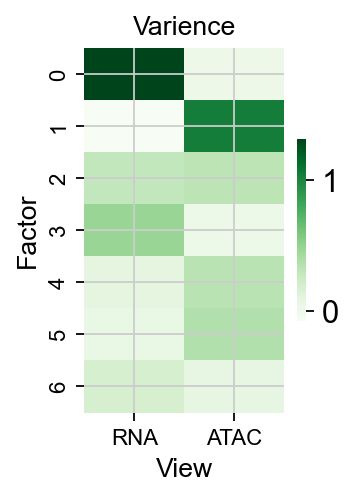

In [17]:
pymofa_obj.plot_r2()

In [18]:
pymofa_obj.get_r2()

,RNA,ATAC
0,1.316585,0.018968
1,-0.080779,1.047071
2,0.287472,0.320996
3,0.472146,0.031148
4,0.095592,0.333661
5,0.054129,0.363245
6,0.189824,0.081352


### Visualize the correlation between factor and celltype

(<Figure size 320x480 with 2 Axes>,
 <Axes: title={'center': 'Correlation'}, xlabel='Factor', ylabel='cell_type'>)

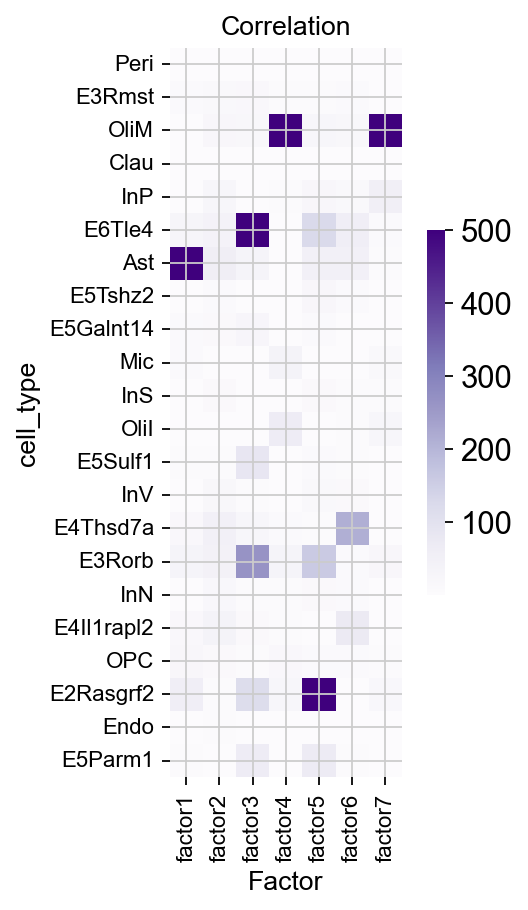

In [19]:
pymofa_obj.plot_cor(rna1,'cell_type',figsize=(4,6))

In [20]:
pymofa_obj.get_cor(rna1,'cell_type')

,factor1,factor2,factor3,factor4,factor5,factor6,factor7
Peri,0.318853,0.384534,1.757568,0.522838,0.485881,0.493366,0.565135
E3Rmst,8.982167,13.902451,17.141229,7.264085,7.450423,8.996937,3.750845
OliM,1.187878,22.773254,20.511708,500.000000,24.467204,20.359880,500.000000
Clau,2.363151,0.881111,1.405640,0.363669,0.079661,3.611718,0.783787
InP,1.195105,23.830979,1.440991,4.845078,23.105033,14.104490,53.517652
E6Tle4,27.801292,40.504784,500.000000,2.811659,124.275006,57.280790,8.473493
Ast,500.000000,59.746788,34.912139,2.901276,48.834094,48.271245,6.024687
E5Tshz2,3.044193,11.531411,1.977301,0.886665,22.188388,8.826331,1.355485
E5Galnt14,11.517458,11.833855,26.070782,3.563853,11.345392,3.340191,2.688997
Mic,9.850426,1.446573,2.047106,38.436338,3.435589,1.424555,15.420949


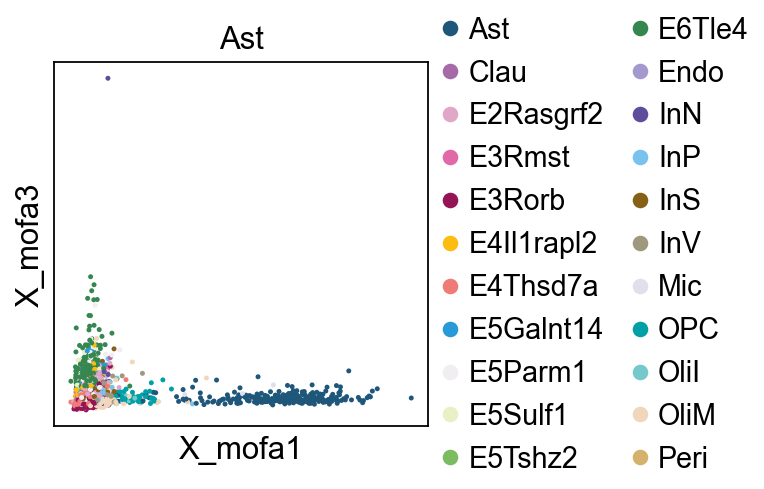

(<Figure size 240x240 with 1 Axes>,
 <Axes: title={'center': 'Ast'}, xlabel='X_mofa1', ylabel='X_mofa3'>)

In [21]:
pymofa_obj.plot_factor(rna1,'cell_type','Ast',figsize=(3,3),
                    factor1=1,factor2=3,)

### Visualize the factor in UMAP

To visualize the GLUE’s learned embeddings, we use the pymde package wrapperin scvi-tools. This is an alternative to UMAP that is GPU-accelerated.

You can use `sc.tl.umap` insteaded.

In [22]:
# from scvi.model.utils import mde
from omicverse.utils import mde
import scanpy as sc
sc.pp.neighbors(rna1, use_rep="X_glue", metric="cosine")
rna1.obsm["X_mde"] = mde(rna1.obsm["X_glue"])

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:24)


[<Axes: title={'center': 'factor1'}, xlabel='X_mde1', ylabel='X_mde2'>,
 <Axes: title={'center': 'factor3'}, xlabel='X_mde1', ylabel='X_mde2'>,
 <Axes: title={'center': 'cell_type'}, xlabel='X_mde1', ylabel='X_mde2'>]

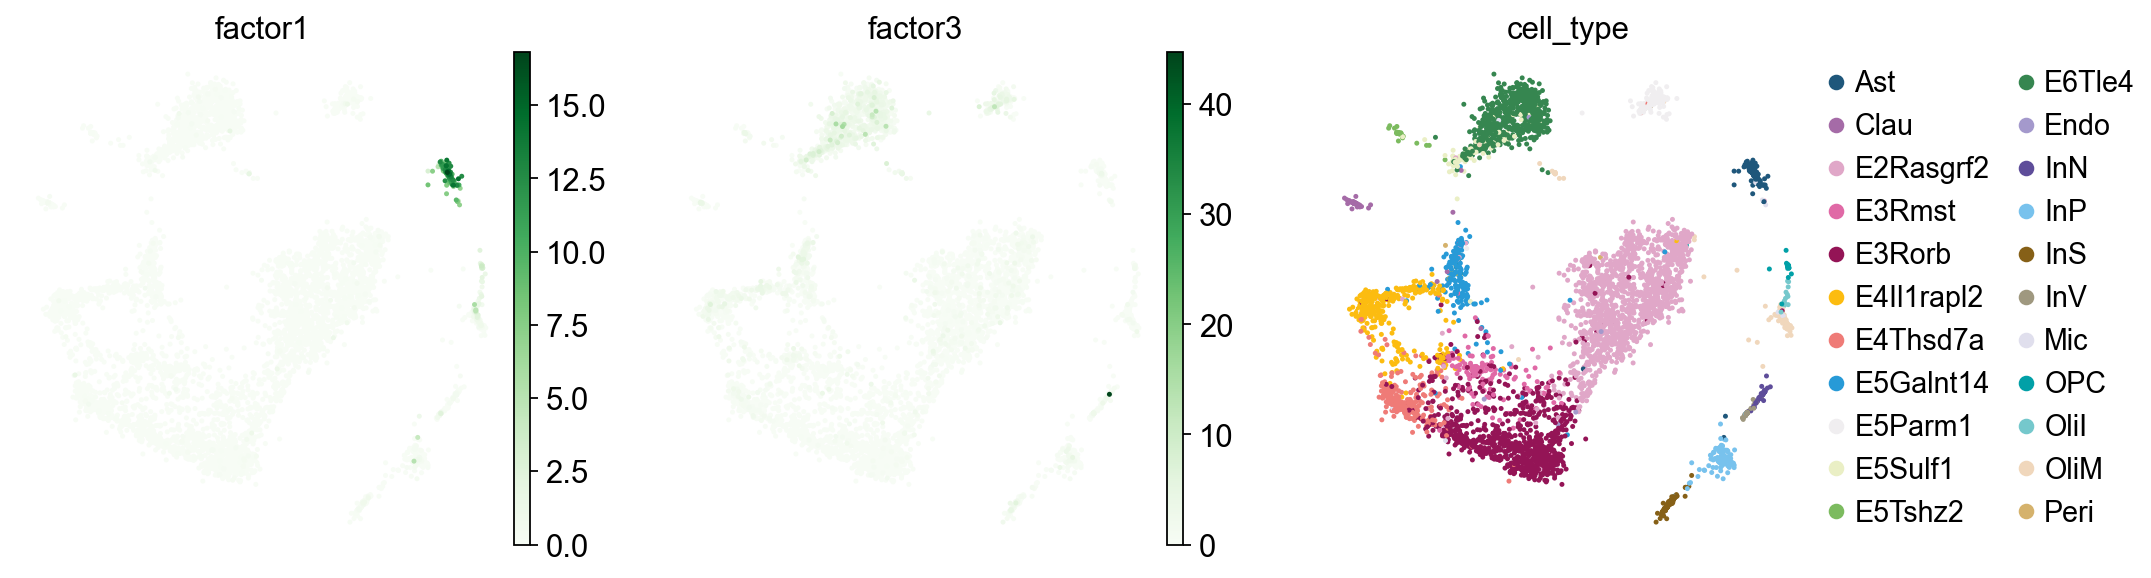

In [23]:
sc.pl.embedding(
    rna1,
    basis="X_mde",
    color=["factor1","factor3","cell_type"],
    frameon=False,
    ncols=3,
    #palette=ov.utils.pyomic_palette(),
    show=False,
    cmap='Greens',
    vmin=0,
)


### Weights ranked
A visualization of factor weights familiar to MOFA and MOFA+ users is implemented with some modifications in `plot_weight_gene_d1`, `plot_weight_gene_d2`, and `plot_weights`.

(<Figure size 240x240 with 1 Axes>,
 <Axes: xlabel='factor_1', ylabel='factor_3'>)

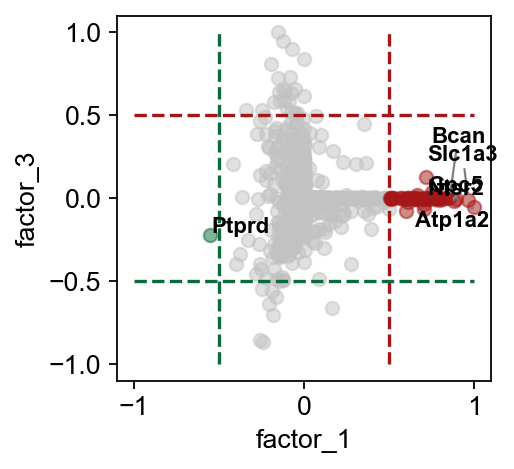

In [24]:
pymofa_obj.plot_weight_gene_d1(view='RNA',factor1=1,factor2=3,)

(<Figure size 240x320 with 1 Axes>,
 <Axes: title={'center': 'factor_1'}, xlabel='Feature rank', ylabel='Weight'>)

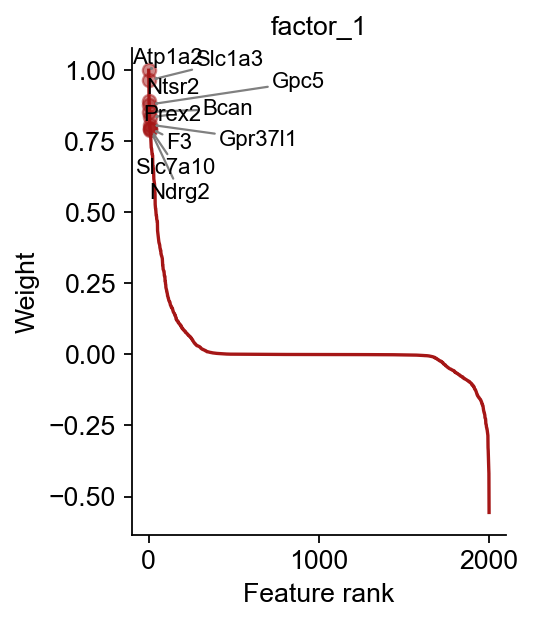

In [25]:
pymofa_obj.plot_weights_gene_factor(view='RNA',factor=1,ascending=False)

### Weights heatmap

While trying to annotate factors, a global overview of top features defining them could be helpful.

computing PCA
    with n_comps=13
    finished (0:00:00)
Storing dendrogram info using `.uns['dendrogram_Factor']`
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


{'mainplot_ax': <Axes: >,
 'group_extra_ax': <Axes: >,
 'gene_group_ax': <Axes: >,
 'color_legend_ax': <Axes: title={'center': 'Mean expression\nin group'}>}

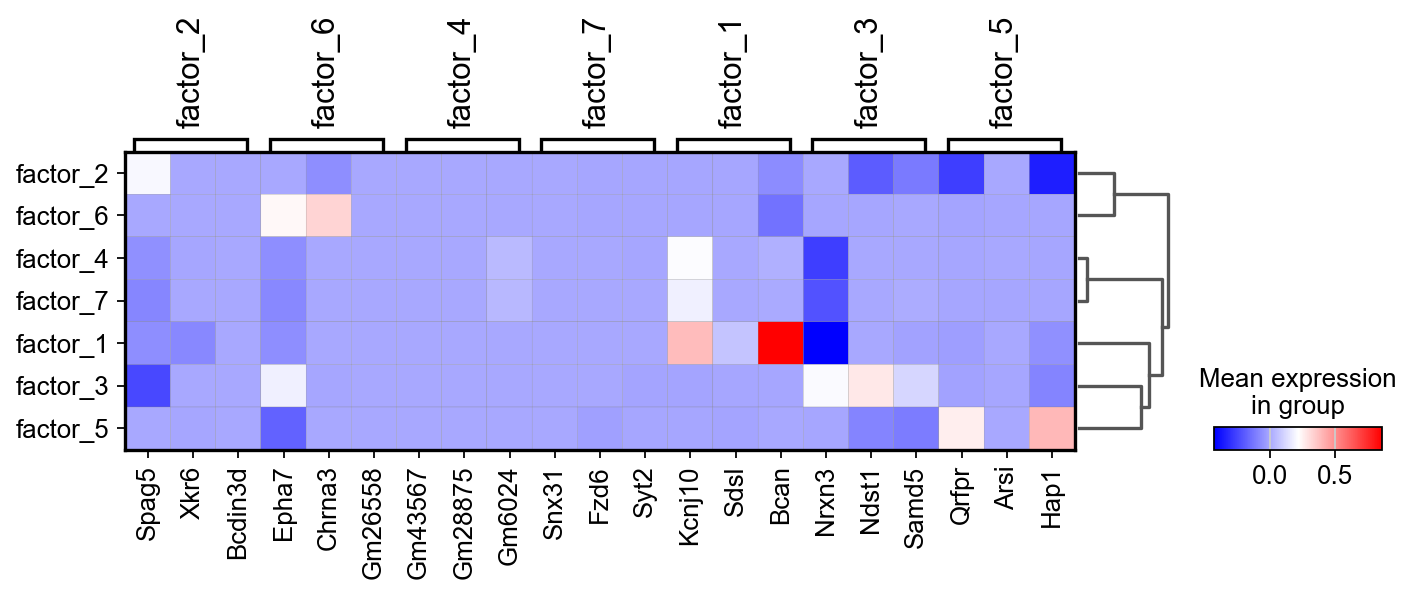

In [26]:
pymofa_obj.plot_top_feature_heatmap(view='RNA', n_pcs=13)